In [1]:
# Torch and related packages
import torch
from torchvision import transforms, datasets, utils
import torch.nn.functional as F
from PIL import Image

# Math and plot utils
import numpy as np
import matplotlib.pyplot as plt

# For profiling performance
import time

# Our model which we train
from models.fast_scnn import FastSCNN

# Custom Utilities
from utils.dataset import IGVCDataset
from utils.train_util import train_net
from utils.common_utils import load_model, output_mask, save_model, img_to_mask

In [2]:
# Setting and checking device
gpuid=0
device = torch.device('cuda:'+str(gpuid) if torch.cuda.is_available() else 'cpu')
torch.cuda.device(device)
print('Device name:', torch.cuda.get_device_properties(device).name)
print('Device id:  ', device)

Device name: GeForce 920M
Device id:   cuda:0


In [3]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(480, 640)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor()
])

# Note that these transforms are applied to all inputs as well as labels (with
# randomized transforms receiving the same seed). So transforms.Grayscale &
# transforms.Normalize is later performed separately (for inputs only).

In [4]:
# Loading train, val and test sets
dataloaders = {}
datasets = {}
datasizes = {}

datasets['train'] = IGVCDataset(imgs_dir='data_train/images', labels_dir='data_train/labels', transform=train_transforms)
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], batch_size=4, shuffle=True, num_workers=2)
datasizes['train'] = len(datasets['train'])

datasets['val'] = IGVCDataset(imgs_dir='data_val/images', labels_dir='data_val/labels', transform=test_transforms)
dataloaders['val'] = torch.utils.data.DataLoader(datasets['val'], batch_size=4, shuffle=True, num_workers=2)
datasizes['val'] = len(datasets['val'])

datasets['test'] = IGVCDataset(imgs_dir='data_test/images', labels_dir='data_test/labels', transform=test_transforms)
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=4, shuffle=False, num_workers=2)
datasizes['test'] = len(datasets['test'])
dataiter = iter(dataloaders['test'])

print('Number of images in each set:', datasizes)

Number of images in each set: {'train': 265, 'val': 201, 'test': 434}


In [5]:
# Loading model
model = FastSCNN(in_channel=1, width_multiplier=0.5, num_classes=2,
                 dropout_prob=0.5).to(device)

In [6]:
# For fine-tuning on already trained parameters
# load_model(model, './model_gray')

Epoch 19/19
----------
train: loss: 0.3064 acc: 74.72%
val:   loss: 0.2446 acc: 74.63%


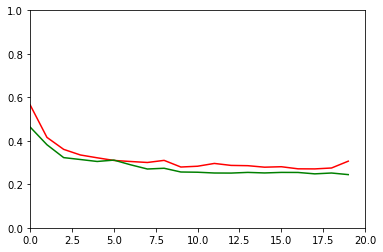

Training complete in 9m 45s
Best Val Loss: 0.244613
Done Training.


In [7]:
# Training the model
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.006, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss(torch.tensor([1, 20], dtype=torch.float).to(device))

model = train_net(model, dataloaders, datasizes, criterion, optimizer_ft,
                  exp_lr_scheduler, device, num_epochs=20)

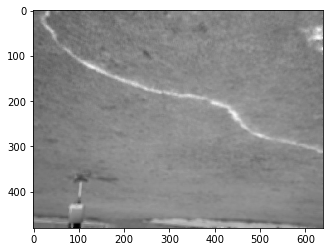

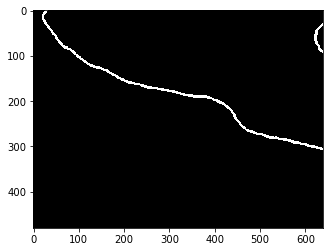

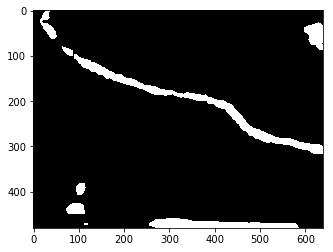

In [8]:
# For visualizing results on test set
img, label = dataiter.next()
plt.imshow(img[0][0], cmap='gray'); plt.show()
plt.imshow(label[0][0], cmap='gray'); plt.show()
output = torch.argmax(model(img.to(device)), 1).detach().cpu()
plt.imshow(output[0], cmap='gray'); plt.show()

In [9]:
# For saving model parameters to a file
# save_model(model, './model_gray')

Model saved to  ./model_gray


In [10]:
# Inference speed testing
gpuid=0
device = torch.device('cuda:'+str(gpuid) if torch.cuda.is_available() else 'cpu')
torch.cuda.device(device)
print('Device name:', torch.cuda.get_device_properties(device).name)

num_images = 100
with torch.no_grad():
    start_time = time.time()
    dataiter = iter(dataloaders['test'])
    for i in range(num_images):
        img, label = dataiter.next()
        pred = output_mask(img, model, device)
    end_time = time.time()

print('Results are as following:')
print('FPS    : {:.3f} fps'.format(num_images/(end_time - start_time)))
print('Latency: {:.3f} seconds'.format((end_time - start_time)/num_images))
# Actual FPS with a python script will usually be higher than a Jupyter notebook.

Device name: GeForce 920M
Results are as following:
FPS    : 8.294 fps
Latency: 0.121 seconds


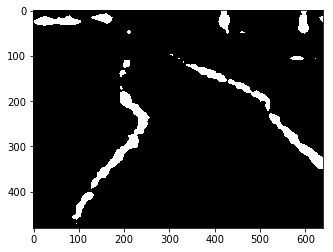

In [11]:
# For testing on an image file
test_transforms = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], 
                         std=[0.5])
])

mask = img_to_mask('data_test/images/11.jpg', model, test_transforms, device)
plt.imshow(mask[0], cmap='gray')
plt.show()